# CrowdTruth medical relation extraction

NLP often relies on the development of a set of gold standard annotations, or *ground truth*, for the purpose of training, testing and evaluation. *Distant supervision* [1] is a helpful solution that has given linked data sets a lot of attention in NLP, however the data can be noisy. Human annotators can help to clean up this noise, however for Clinical NLP domain knowledge is usually believed to be required from annotators, making the process for acquiring ground truth more difficult. In addition, current methods for collecting annotation attempt to minimize disagreement between annotators, and therefore fail to model the ambiguity inherent in language. The lack of annotated datasets for training and benchmarking is therefore one of the main challenges of Clinical Natural Language Processing.

We propose the **[CrowdTruth](http://crowdtruth.org/)** method for collecting medical ground truth through crowdsourcing, based on the observation that disagreement between annotators can be used to capture ambiguity in text. This repository contains a ground truth corpus for medical relation extraction, acquired with crowdsourcing and processed with **[CrowdTruth](http://crowdtruth.org/)** metrics.

Download the data from GitHub: [Medical-Relation-Extraction](https://github.com/CrowdTruth/Medical-Relation-Extraction/).

More details about the corpus can be found in the papers:

* Anca Dumitrache, Lora Aroyo, Chris Welty: **[CrowdTruth Measures for Language Ambiguity: The Case of Medical Relation Extraction](http://www.ancad.ro/2015/09/01/crowdtruth-measures-for-language-ambiguity)**. [LD4IE](http://oak.dcs.shef.ac.uk/ld4ie2015/LD4IE2015/Overview.html) at [ISWC 2015](http://iswc2015.semanticweb.org/).
* Anca Dumitrache, Lora Aroyo, Chris Welty: **[Achieving Expert-Level Annotation Quality with CrowdTruth: The Case of Medical Relation Extraction](http://www.ancad.ro/2015/08/14/achieving-expert-level-annotation-quality-with-crowdtruth/)**. [BDM2I](https://sbmi.uth.edu/ontology/bdm2i.htm) at [ISWC 2015](http://iswc2015.semanticweb.org/).

## Data

The dataset used in our experiments contains 902 medical sentences extracted from PubMed article abstracts. The MetaMap parser [2] ran over the corpus to identify medical terms from the UMLS vocabulary [3]. Distant supervision [1] was used to select sentences with pairs of terms that are linked in UMLS by one of our chosen seed medical relations. The intuition of distant supervision is that since we know the terms are related, and they are in the same sentence, it is more likely that the sentence expresses a relation between them. The seed relations were restricted to a set of eleven UMLS relations important for clinical decision making.

For collecting annotations from medical experts, we employed medical students, in their third year at American universities, that had just taken United States Medical Licensing Examination (USMLE) and were waiting for their results. Each sentence was annotated by exactly one person. The annotation task consisted of deciding whether or not the UMLS seed relation discovered by distant supervision is present in the sentence for the two selected terms.

## Crowdsourcing

![Fig.1: CrowdTruth Workflow for Medical Relation Extraction on CrowdFlower.](img/task_workflow_2.png)

The crowdsourced annotation is performed in a workflow of three tasks. The sentences were pre-processed to determine whether the terms found with distant supervision are complete or not; identifying complete medical terms is difficult, and the automated method left a number of terms still incomplete, which was a significant source of error for the crowd in subsequent stages, so the incomplete terms were sent through a crowdsourcing task (*FactSpan*) in order to get the full word span of the medical terms. Next, the sentences with the corrected term spans were sent to a relation extraction task (*RelEx*), where the crowd was asked to decide which relation holds between the two extracted terms. The workers were able to read the definition of each relation, and could choose any number of relations per sentence. Finally, the results from *RelEx* were passed to another crowdsourcing task (*RelDir*) to determine the direction of the relation with regards to the two extracted terms. (*FactSpan* and *RelDir*) were added to the basic *RelEx* task to correct the most common sources of errors from the crowd.

## Relation extraction classifier

The sentences together with the relation annotations were then used to train a manifold model for relation extraction [4]. This model was developed for the medical domain, and tested for the relation set that we employ. It is trained per individual relation, by feeding it both positive and negative data. It offers support for both discrete labels, and real values for weighting the confidence of the training data entries, with positive values in (0,1], and negative values in [-1,0). 


## Dataset files

```
|--cause_relation_ground_truth.csv
```
This file contains the processed ground truth for the medical *cause* relation, in comma-separated format. The columns are:
* *Sent_id*: unique ID of the data entry
* *sentence*: medical sentence
* *term1, term2*: the 2 medical terms after correction with *FactSpan* and *RelDir*; together, they express the relation: ```term1 cause of term2```
* *b1, b2*: the beginning position of each term in the sentence
* *e1, e2*: the end position of each term in the sentence
* *senrel_score*: the sentence relation score of the *cause* relation; using cosine similarity over the aggregated crowd data, it computes the likelihood that *cause* is expressed between the 2 terms in the sentence
* *crowd*: the score used to train the relation extraction classifier with crowd data; it is the sentence-relation score, with a threshold to select positive and negative examples equal to 0.5, and rescaled in [0.85, 1] for positives, and [-1, -0.85] for negatives.
* *single*: discrete labels for every sentence are taken from one randomly selected crowd worker who annotated the sentence.
* *baseline*: discrete (positive or negative) labels are given for each sentence by the distant supervision [1] method
* *expert*: discrete labels based on an expert’s judgment as to whether the *baseline* label is correct
* *test_eval*: manual evaluation scores over the sentences where *crowd* and *expert* disagreed, used for evaluating the classifier; the sentence-relation score threshold was set at 0.7 for maximum agreement; sentences scored with 0 were determined to be ambiguous and were removed from testing
* *distant supervision term 1, distant supervision term 2*: the original terms as extracted by distant supervision, before correction with *FactSpan*
* *UMLS seed relation*: the UMLS [4] relation used as a seed in distant supervision to find the given entry

```
|--/raw
| |--/FactSpan
| |--/RelEx
| |--/RelDir
```
The raw data collected from crowdsourcing for each of the 3 tasks.

## Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ground_truth = pd.read_csv("cause_relation_ground_truth.csv")

### Crowd and expert agreement per negative/positive threshold for cause.

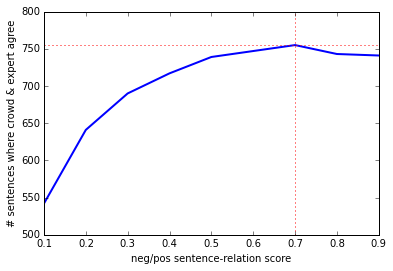

In [2]:
crowd_exp_agr = np.zeros(shape=(9, 2))

for idx in range(1, 10):
    thresh = idx / 10.0
    sent_in_agr = sum(((ground_truth['senrel_score'] >= thresh) & (ground_truth['expert'] > 0)) |
                      ((ground_truth['senrel_score'] < thresh) & (ground_truth['expert'] < 0)))
    crowd_exp_agr[idx - 1, 0] = thresh
    crowd_exp_agr[idx - 1, 1] = sent_in_agr

plt.plot(crowd_exp_agr[:,0], crowd_exp_agr[:,1], lw = 2)
plt.xlim(0.1,0.9)

max_thresh = np.argmax(crowd_exp_agr[:, 1])
plt.axvline(x = crowd_exp_agr[max_thresh, 0], color = 'r', ls = ':')
plt.axhline(y = crowd_exp_agr[max_thresh, 1], color = 'r', ls = ':')

plt.ylabel('# sentences where crowd & expert agree')
plt.xlabel('neg/pos sentence-relation score')

### Annotation quality F1 per negative/positive threshold for cause.

This measure was computed prior to any classifier training, by using the manually evaluated scores (the *test_eval* column in the data file) as a gold standard.

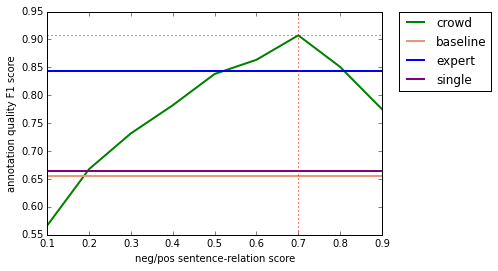

In [4]:
def f1_score(pred, gold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for idx in range(0, len(pred)):
        if gold[idx] != 0:
            if pred[idx] > 0 and gold[idx] > 0:
                tp += 1.0
            elif pred[idx] > 0 and gold[idx] < 0:
                fp += 1.0
            elif pred[idx] < 0 and gold[idx] < 0:
                tn += 1.0
            else:
                fn += 1.0
    
    return 2.0 * tp / (2.0 * tp + fp + fn)


test_partition = ground_truth['test_eval']
for idx in range(0, len(test_partition)):
    if np.isnan(test_partition[idx]):
        test_partition[idx] = ground_truth['expert'][idx]

crowd_ann_quality_f1 = np.zeros(shape=(9, 2))
for idx in range(1, 10):
    thresh = idx / 10.0
    crowd_score = (ground_truth['senrel_score'] >= thresh) * 2 - 1
    crowd_ann_quality_f1[idx - 1, 0] = thresh
    crowd_ann_quality_f1[idx - 1, 1] = f1_score(crowd_score, test_partition)

plt.plot(crowd_ann_quality_f1[:,0], crowd_ann_quality_f1[:,1], color = 'g', lw = 2, label = "crowd")
plt.xlim(0.1,0.9)

plt.axhline(y = f1_score(ground_truth['baseline'].copy(), test_partition),
            color = 'darksalmon', lw = 2, label = "baseline")
plt.axhline(y = f1_score(ground_truth['expert'].copy(),test_partition),
            color = 'b', lw = 2, label = "expert")
plt.axhline(y = f1_score(ground_truth['single'].copy(), test_partition),
            color = 'purple', lw = 2, label = "single")

max_thresh = np.argmax(crowd_ann_quality_f1[:, 1])
plt.axvline(x = crowd_ann_quality_f1[max_thresh, 0], color = 'r', ls = ':')
plt.axhline(y = crowd_ann_quality_f1[max_thresh, 1], color = 'r', ls = ':')

plt.ylabel('annotation quality F1 score')
plt.xlabel('neg/pos sentence-relation score')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Classifier evaluation results

In [5]:
classifier_results = pd.read_csv("aggregate/classifier_results.csv")
classifier_results

,dataset,P,R,F1,Accuracy
0,crowd 0.1 neg/pos threshold,0.353604,0.959996,0.516285,0.529470
1,crowd 0.2 neg/pos threshold,0.451638,0.902775,0.600743,0.685901
2,crowd 0.3 neg/pos threshold,0.504475,0.848493,0.631943,0.741597
3,crowd 0.4 neg/pos threshold,0.531107,0.765930,0.625611,0.755612
4,crowd 0.5 neg/pos threshold,0.565439,0.743213,0.642031,0.784087
5,crowd 0.6 neg/pos threshold,0.604395,0.680387,0.636557,0.803436
6,crowd 0.7 neg/pos threshold,0.619955,0.610733,0.613310,0.800969
7,crowd 0.8 neg/pos threshold,0.635180,0.476502,0.540332,0.791950
8,crowd 0.9 neg/pos threshold,0.694369,0.375856,0.481487,0.793094
9,expert,0.672085,0.604660,0.638103,0.818652


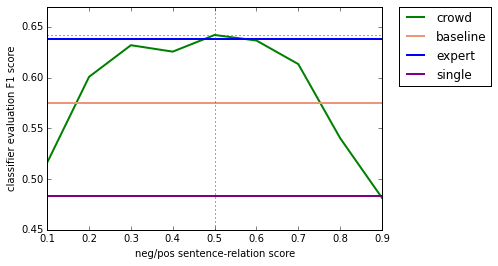

In [6]:
plt.plot([x / 10.0 for x in range(1, 10)], classifier_results["F1"][range(0,9)],
         color = 'g', lw = 2, label = "crowd")
plt.xlim(0.1, 0.9)
plt.ylim(0.45, 0.67)

plt.axhline(y = classifier_results["F1"][11],
            color = 'darksalmon', lw = 2, label = "baseline")
plt.axhline(y = classifier_results["F1"][9],
            color = 'b', lw = 2, label = "expert")
plt.axhline(y = classifier_results["F1"][10],
            color = 'purple', lw = 2, label = "single")

plt.axvline(x = 0.5, color = 'r', ls = ':')
plt.axhline(y = classifier_results["F1"][4], color = 'r', ls = ':')

plt.ylabel('classifier evaluation F1 score')
plt.xlabel('neg/pos sentence-relation score')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Learning curves

In [7]:
f1_learning_curves = pd.read_csv("aggregate/f1_learning_curves.csv")
f1_learning_curves

,sentences,crowd 0.5,expert,single,baseline
0,100,0.418969,0.399480,0.362405,0.400351
1,200,0.468266,0.533300,0.394047,0.479602
2,300,0.507137,0.535282,0.425924,0.525753
3,400,0.550221,0.563789,0.414762,0.542093
4,500,0.578371,0.599502,0.435369,0.573187
5,600,0.631057,0.620284,0.454875,0.582943
6,720,0.642031,0.638103,0.483020,0.575372


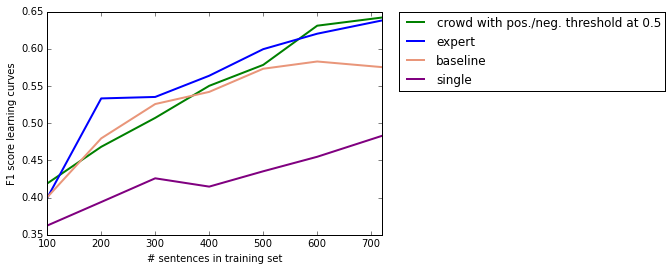

In [8]:
plt.plot(f1_learning_curves['sentences'], f1_learning_curves['crowd 0.5'],
         color = 'g', lw = 2, label = "crowd with pos./neg. threshold at 0.5")
plt.xlim(f1_learning_curves['sentences'][0], f1_learning_curves['sentences'][6])

plt.plot(f1_learning_curves['sentences'], f1_learning_curves['expert'],
         color = 'b', lw = 2, label = "expert")
plt.plot(f1_learning_curves['sentences'], f1_learning_curves['baseline'],
         color = 'darksalmon', lw = 2, label = "baseline")
plt.plot(f1_learning_curves['sentences'], f1_learning_curves['single'],
         color = 'purple', lw = 2, label = "single")

plt.ylabel('F1 score learning curves')
plt.xlabel('# sentences in training set')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)